In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
from torchvision import transforms
from PIL import Image
import os
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input director
        

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.dataloader import default_collate

In [3]:
print("Running on: ")
if torch.cuda.is_available(): 
    dev = "cuda:0"
    print("Cuda")
else:
    dev = "cpu"
    print("CPU")
device = torch.device(dev) 
a = torch.zeros(4,3) 
a = a.to(device)

Running on: 
Cuda


In [4]:
labels = []
files = []
for dirname, _, fnames in os.walk('/kaggle/input/fruit-and-vegetable-image-recognition/train'):
    for filename in fnames:
        labels.append(dirname.split("/")[-1])
        files.append(os.path.join(dirname, filename))
labels = np.array(labels)
files = np.array(files)

In [5]:
#number of data we have
files.shape

(3115,)

In [6]:
labels

array(['capsicum', 'capsicum', 'capsicum', ..., 'soy beans', 'soy beans',
       'soy beans'], dtype='<U13')

In [7]:
convert_tensor = transforms.ToTensor()

In [8]:
# Load all images
imgs = [convert_tensor(Image.open(f).resize((160, 160), Image.Resampling.BILINEAR)).numpy()
[0:3] for f in files]

In [9]:
#Make images with only 1 channel 3 channels
imgs = torch.tensor(np.array([i if i.shape[0] == 3 else np.array([i[0],i[0],i[0]]) for i in imgs]))

In [10]:
imgs.shape

torch.Size([3115, 3, 160, 160])

In [11]:
#check that all images ahve the same size
for idx, i in enumerate(imgs):
    if i.shape[0] != 3:
        print(idx)

In [12]:
### labels
labels_index = np.unique(labels) # array of 36 uniques labels
labels_idx_only = [np.where(labels_index == l)[0][0] for l in labels] #
labels_as_array = torch.stack([F.one_hot(torch.tensor(k), len(labels_index)) for k in labels_idx_only], dim=0).type(torch.FloatTensor)

In [13]:
class CustomImageDataset(Dataset):
    def __init__(self, transform=None, target_transform=None):
        self.imgs = imgs
        self.img_labels = labels
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        image = self.imgs[idx]
        label = labels_idx_only[idx]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [14]:
class Net(nn.Module):
    def __init__(self, size = 300, channels = 3, labels = 36):
        super(Net, self).__init__()
        kernel_size_1 = 5
        kernel_size_2 = 5
        conv1_channels = 80
        conv2_channels = 40
        conv1_out_dim = int((size - kernel_size_1 + 1) / 2)
        conv2_out_dim = int((conv1_out_dim - kernel_size_2 + 1) / 2)
        # length of x
        self.rescalesize_0 = size * size * channels
        self.block1 = nn.Sequential(         
            nn.LazyConv2d(conv1_channels, kernel_size=kernel_size_1),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.LazyConv2d(conv2_channels, kernel_size=kernel_size_2),
            nn.Dropout(),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.LazyBatchNorm2d(),
            nn.Flatten()
        )
        #length of data after block1
        self.rescalesize_1 = int(conv2_out_dim * conv2_out_dim * conv2_channels)
        # residual connection projects data directly into rescalesize
        #self.block2 = nn.Sequential(
        #    nn.MaxPool2d(8),
        #    nn.Flatten(),
        #    nn.LazyLinear(self.rescalesize_1)
        #)
        # linear layer
        self.block3 = nn.Sequential(
            nn.LazyLinear(1000),
            nn.Dropout(),
            nn.ReLU(),
            nn.LazyLinear(labels),
            nn.LogSoftmax(dim=1)
        )
        print(size)
        print(conv1_out_dim)
        print(conv2_out_dim)
        print(self.rescalesize_0)
        print(self.rescalesize_1)

    def forward(self, x):
        out = self.block1(x)
        #out = out + self.block2(x)
        out = self.block3(out)
        return out

In [15]:
### now training
n_epochs = 10
batch_size_train = 64
learning_rate = 3e-4
momentum = 0.5
log_interval = 10
color_channels = imgs.shape[1]

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [16]:
train_loader = DataLoader(CustomImageDataset(), batch_size=batch_size_train, shuffle=True, collate_fn=lambda x: tuple(x_.to(device) for x_ in default_collate(x)))

In [17]:
network = Net(size = imgs.shape[2], channels = imgs.shape[1], labels = np.unique(labels).shape[0])
network.to(device)
optimizer = optim.Adam(network.parameters(), lr=learning_rate)


160
78
37
76800
54760


In [18]:
train_losses = []
train_counter = []
test_losses = []

In [19]:
log = 0
def train(epoch):
    network.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = network(data)
        if log == 1:
            print("data")
            print(data.shape)
            print("target")
            print(target.shape)
            print("output")
            print(output.shape)
            exit
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data),
                len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item()
            ))
            train_losses.append(loss.item())
            train_counter.append(
                (batch_idx*64) + ((epoch-1)*len(train_loader.dataset))
            )
            torch.save(network.state_dict(), '/kaggle/working/model.pth')
            torch.save(optimizer.state_dict(), '/kaggle/working/optimizer.pth')
            

In [20]:
for epoch in range(1,n_epochs+1):
    train(epoch)

Train Epoch: 1 [0/3115 (0%)]	Loss: 3.611623
Train Epoch: 1 [640/3115 (20%)]	Loss: 3.087609
Train Epoch: 1 [1280/3115 (41%)]	Loss: 3.336303
Train Epoch: 1 [1920/3115 (61%)]	Loss: 3.053297
Train Epoch: 1 [2560/3115 (82%)]	Loss: 3.197084
Train Epoch: 2 [0/3115 (0%)]	Loss: 1.902058
Train Epoch: 2 [640/3115 (20%)]	Loss: 1.796969
Train Epoch: 2 [1280/3115 (41%)]	Loss: 2.142822
Train Epoch: 2 [1920/3115 (61%)]	Loss: 1.879279
Train Epoch: 2 [2560/3115 (82%)]	Loss: 1.465321
Train Epoch: 3 [0/3115 (0%)]	Loss: 0.835811
Train Epoch: 3 [640/3115 (20%)]	Loss: 0.862840
Train Epoch: 3 [1280/3115 (41%)]	Loss: 0.812928
Train Epoch: 3 [1920/3115 (61%)]	Loss: 0.745315
Train Epoch: 3 [2560/3115 (82%)]	Loss: 0.782363
Train Epoch: 4 [0/3115 (0%)]	Loss: 0.467238
Train Epoch: 4 [640/3115 (20%)]	Loss: 0.281250
Train Epoch: 4 [1280/3115 (41%)]	Loss: 0.262165
Train Epoch: 4 [1920/3115 (61%)]	Loss: 0.708486
Train Epoch: 4 [2560/3115 (82%)]	Loss: 0.276513
Train Epoch: 5 [0/3115 (0%)]	Loss: 0.341482
Train Epoch: 5 [

Text(0, 0.5, 'negative log likelihood loss')

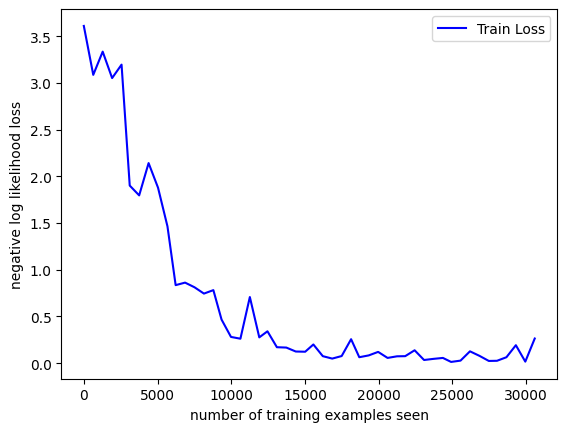

In [21]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.legend(['Train Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
